##### 1. 定义算法
TD3_BC算法是在TD3算法的基础上进行改进，TD3_BC算法在计算 actor 网络损失时引入与专家动作数据做均方差的损失，以及对 state 采用归一化，其余结构与TD3基本一致。

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np

##### 1.1 定义网路
这里分别定义了 critic 和 mlp 网络，mlp 网络用作 actor 网络

In [12]:
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(Critic,self).__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

class MLP(nn.Module):
    def __init__(self, input_dim,output_dim,hidden_dim=128):
        """ 初始化q网络，为全连接网络
            input_dim: 输入的特征数即环境的状态维度
            output_dim: 输出的动作维度
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, output_dim) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

##### 1.2 TD3_BC算法

In [13]:
class TD3_BC(object):
	def __init__(self,cfg):
		'''智能体类
        Args:array
            cfg (class): 超参数类
        '''
		self.gamma = cfg.gamma
		self.actor_lr = cfg.actor_lr
		self.critic_lr = cfg.critic_lr
		self.policy_noise = cfg.policy_noise # noise added to target policy during critic update
		self.noise_clip = cfg.noise_clip # range to clip target policy noise
		self.expl_noise = cfg.expl_noise # std of Gaussian exploration noise
		self.policy_freq = cfg.policy_freq # policy update frequency
		self.batch_size =  cfg.batch_size 
		self.tau = cfg.tau
		self.sample_count = 0
		self.explore_steps = cfg.explore_steps # exploration steps before training
		self.device = torch.device(cfg.device)
		self.n_actions = cfg.n_actions
		self.action_space = cfg.action_space
		self.actor_input_dim = cfg.n_states
		self.actor_output_dim = cfg.n_actions
		self.critic_input_dim = cfg.n_states + cfg.n_actions
		self.critic_output_dim = 1

		self.action_scale = torch.tensor((self.action_space.high - self.action_space.low)/2, device=self.device, dtype=torch.float32).unsqueeze(dim=0) # 动作空间放缩
		self.action_bias = torch.tensor((self.action_space.high + self.action_space.low)/2, device=self.device, dtype=torch.float32).unsqueeze(dim=0) # 动作空间平移
		self.actor = MLP(self.actor_input_dim, self.actor_output_dim, hidden_dim = cfg.actor_hidden_dim).to(self.device)
		self.actor_target = MLP(self.actor_input_dim, self.actor_output_dim, hidden_dim = cfg.actor_hidden_dim).to(self.device)
		self.actor_target.load_state_dict(self.actor.state_dict())

		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = self.actor_lr)

		self.critic_1 = Critic(self.critic_input_dim, self.critic_output_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_2 = Critic(self.critic_input_dim, self.critic_output_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_1_target = Critic(self.critic_input_dim, self.critic_output_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_2_target = Critic(self.critic_input_dim, self.critic_output_dim, hidden_dim = cfg.critic_hidden_dim).to(self.device)
		self.critic_1_target.load_state_dict(self.critic_1.state_dict())
		self.critic_2_target.load_state_dict(self.critic_2.state_dict())
		
		self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr = self.critic_lr)
		self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr = self.critic_lr)

		self.alpha = cfg.alpha

		self.expert_path = f"{cfg.expert_path}" # 专家数据路径
		with open(self.expert_path, 'rb') as f:
			expert_data = pickle.load(f)
		self.expert_states = np.array(expert_data['states']) 
		self.expert_actions = np.array(expert_data['actions'])
		self.expert_next_states = np.array(expert_data['next_states']) 
		self.expert_rewards = np.array(expert_data['rewards'])
		self.expert_terminals = np.array(expert_data['terminals'])

		if cfg.normalize:
			self.mean, self.std, self.expert_states, self.expert_next_states = self.normalize_states(self.expert_states, self.expert_next_states) # 归一化专家状态
		else:
			self.mean, self.std = 0, 1

	def normalize_states(self, expert_states, expert_next_states, eps = 1e-3):
		'''归一化 state
		Args:
			expert_states (array): 专家状态
			expert_next_states (array): 专家下一个状态
			eps (float, optional): 防止 std 为 0 的参数. Defaults to 1e-3.
		Returns:
			mean (float): 均值
			std (float): 方差
			expert_states (array): 归一化后的专家状态
			expert_next_states (array): 归一化后的专家下一个状态
		'''
		mean = expert_states.mean(0,keepdims=True)
		std = expert_states.std(0,keepdims=True) + eps
		# print (mean, std)
		expert_states = (expert_states - mean)/std
		expert_next_states = (expert_next_states - mean)/std
		return mean, std, expert_states, expert_next_states 

	def sample_action(self, state):
		'''采样动作
		Args:
			state (array): 状态
		Returns:
			action (array): 动作
		'''
		self.sample_count += 1
		if self.sample_count < self.explore_steps:
			return self.action_space.sample()
		else:
			state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
			action = torch.tanh(self.actor(state))
			action = self.action_scale * action + self.action_bias # 对动作进行放缩和平移
			action = action.detach().cpu().numpy()[0]
			action_noise = np.random.normal(0, self.action_scale.cpu().numpy()[0] * self.expl_noise, size=self.n_actions) # 高斯噪音
			action = (action + action_noise).clip(self.action_space.low, self.action_space.high)
			return action

	@torch.no_grad()
	def predict_action(self, state):
		'''预测动作
        Args:
            state (array): 状态
        Returns:
            action (array): 动作
        '''
		state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
		action = torch.tanh(self.actor(state))
		action = self.action_scale * action + self.action_bias
		return action.detach().cpu().numpy()[0]

	def update(self, state, action, next_state, reward, done):
		'''更新网络
		Args:
			state (array): 状态
			action (array): 动作
			next_state (array): 下一状态
			reward (array): 奖励
			done (array): 是否结束
		'''
		# convert to tensor
		state = torch.tensor(np.array(state), device=self.device, dtype=torch.float32)
		action = torch.tensor(np.array(action), device=self.device, dtype=torch.float32)
		next_state = torch.tensor(np.array(next_state), device=self.device, dtype=torch.float32)
		reward = torch.tensor(reward, device=self.device, dtype=torch.float32).unsqueeze(1)
		done = torch.tensor(done, device=self.device, dtype=torch.float32).unsqueeze(1)

		# update critic
		noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
		next_action = ((torch.tanh(self.actor_target(next_state)) + noise) * self.action_scale + self.action_bias).clamp(-self.action_scale+self.action_bias, self.action_scale+self.action_bias)
		next_sa = torch.cat([next_state, next_action], 1) # shape:[train_batch_size,n_states+n_actions]
		target_q1, target_q2 = self.critic_1_target(next_sa).detach(), self.critic_2_target(next_sa).detach()
		target_q = torch.min(target_q1, target_q2) # shape:[train_batch_size,n_actions] 
		target_q = reward + self.gamma * target_q * (1 - done) # 目标 Q 值
		sa = torch.cat([state, action], 1)
		current_q1, current_q2 = self.critic_1(sa), self.critic_2(sa) # 当前 Q 值
		# compute critic loss
		critic_1_loss = F.mse_loss(current_q1, target_q)
		critic_2_loss = F.mse_loss(current_q2, target_q)
		self.critic_1_optimizer.zero_grad()
		critic_1_loss.backward()
		self.critic_1_optimizer.step()
		self.critic_2_optimizer.zero_grad()
		critic_2_loss.backward()
		self.critic_2_optimizer.step()
		# Delayed policy updates
		if self.sample_count % self.policy_freq == 0:
			# compute actor loss

			probs = torch.tanh(self.actor(state))
			probs_scale = self.action_scale * probs + self.action_bias # 对动作进行放缩和平移
			q_critic = self.critic_1(torch.cat([state, probs_scale], 1))
			# with torch.no_grad():
			lmbda = self.alpha/q_critic.abs().mean().detach() # 计算 Q 值的权重
			# TD3 + BC
			actor_loss = - lmbda * q_critic.mean() + F.mse_loss(probs_scale, action) # actor 网络更新目标为保证策略网络输出动作接近专家动作的基础上最大化动作 Q 值

			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()
			## 软更新 critic 网络和 actor 网络
			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
			for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
			for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

	def save_model(self, fpath):
		'''保存网络权重
        Args:
            fpath (str): 保存权重文件路径
        '''
		from pathlib import Path
        # create path
		Path(fpath).mkdir(parents=True, exist_ok=True)
		torch.save(self.critic_1.state_dict(), f"{fpath}/critic_1.pth")
		torch.save(self.critic_2.state_dict(), f"{fpath}/critic_2.pth")
		torch.save(self.actor.state_dict(), f"{fpath}/actor.pth")

	def load_model(self, fpath):
		'''加载网络权重
        Args:
            fpath (str): 加载权重文件路径
        '''
		critic_1_ckpt = torch.load(f"{fpath}/critic_1.pth", map_location=self.device)
		critic_2_ckpt = torch.load(f"{fpath}/critic_2.pth", map_location=self.device)
		actor_ckpt = torch.load(f"{fpath}/actor.pth", map_location=self.device)
		self.critic_1.load_state_dict(critic_1_ckpt)
		self.critic_2.load_state_dict(critic_2_ckpt)
		self.actor.load_state_dict(actor_ckpt)

##### 2. 模型训练与测试

In [14]:
def train(cfg, env, agent): 
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    train_iterations = cfg.train_iterations # 每回合训练专家数据论次
    batch_size = cfg.batch_size
    expert_states = agent.expert_states; expert_actions = agent.expert_actions
    expert_next_states = agent.expert_next_states; expert_rewards = agent.expert_rewards
    expert_terminals = agent.expert_terminals
    for i_ep in range(cfg.train_eps):
        state, info = env.reset(seed=cfg.seed)  # reset and obtain initial state
        for _ in range(train_iterations):
            sample_indices = np.random.randint(low=0,
                                            high=expert_states.shape[0],
                                            size=batch_size)
            agent.update(expert_states[sample_indices], expert_actions[sample_indices], expert_next_states[sample_indices], \
                expert_rewards[sample_indices], expert_terminals[sample_indices])
        res = test_one_episode(cfg, env, agent) # 测试当前 agent 在一局游戏中的奖励和步数
        if (i_ep+1)%10 == 0:
            print (f"iter: {i_ep+1}/{cfg.train_eps}, Reward: {res['ep_reward']:.3f}, Step: {res['ep_step']}")
        rewards.append(res['ep_reward'])
    print("完成训练！")
    return {'rewards':rewards}

def test_one_episode(cfg, env, agent):
    ep_reward = 0  # reward per episode
    ep_step = 0
    state, info = env.reset(seed=cfg.seed)  # reset and obtain initial state
    for _ in range(cfg.max_steps):
        ep_step += 1
        state = (np.array(state).reshape(1,-1) - agent.mean)/agent.std # 归一化 state
        state = state[0]

        action = agent.predict_action(state)  # sample action
        next_state, reward, terminated, truncated, info = env.step(action)  # update env and return transitions under new_step_api of OpenAI Gym
        state = next_state  # update next state for env
        ep_reward += reward  #
        if terminated:
            break
    return {'ep_reward':ep_reward,'ep_step':ep_step}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        res = test_one_episode(cfg, env, agent)
        rewards.append(res['ep_reward'])
        print (f"iter: {i_ep+1}/{cfg.test_eps}, Reward: {res['ep_reward']:.3f}, Step: {res['ep_step']}")
    print("完成测试！")
    return {'rewards':rewards}, agent

##### 3. 定义环境

In [15]:
import gymnasium
import os
import random
def all_seed(seed = 1):
    ''' 万能的seed函数
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gymnasium.make(cfg.env_name) # 创建环境
    all_seed(seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    agent = TD3_BC(cfg)
    return env,agent

##### 3. 设置参数

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self) -> None:
        ## 通用参数
        self.env_name = "HalfCheetah-v2" # name of environment
        self.new_step_api = True # whether to use new step api of gym
        self.wrapper = None # wrapper of environment
        self.render = False # whether to render environment
        self.render_mode = "human" # 渲染模式, "human" 或者 "rgb_array"
        self.algo_name = "TD3_BC" # name of algorithm
        self.mode = "train" # train or test
        self.mp_backend = "mp" # 多线程框架，ray或者mp(multiprocessing)，默认mp
        self.seed = 1 # random seed
        self.device = "cuda" # device to use
        self.train_eps = 1200 # number of episodes for training
        self.test_eps = 10 # number of episodes for testing
        self.eval_eps = 10 # number of episodes for evaluation
        self.eval_per_episode = 5 # evaluation per episode
        self.max_steps = 1000 # max steps for each episode
        self.load_checkpoint = False
        self.load_path = "tasks" # path to load model
        self.show_fig = False # show figure or not
        self.save_fig = True # save figure or not

        ## TD3_BC参数
        self.explore_steps = 10000  # exploration steps before training
        self.policy_freq = 2  # policy update frequency
        self.actor_lr = 0.0005 # actor learning rate 3e-4
        self.critic_lr = 0.0005 # critic learning rate
        self.actor_hidden_dim = 256 # actor hidden layer dimension
        self.critic_hidden_dim = 256 # critic hidden layer dimension
        self.gamma = 0.99 # discount factor
        self.tau = 0.005 # target smoothing coefficient
        self.policy_noise = 0.2 # noise added to target policy during critic update
        self.expl_noise = 0.1 # std of Gaussian exploration noise
        self.noise_clip = 0.5 # range to clip target policy noise
        self.batch_size = 256 # batch size for both actor and critic
        self.buffer_size = 1000000 # replay buffer size

        self.alpha = 5 # the para to calculate the scalar lambda
        self.train_iterations = 1500 # 训练的迭代次数
        self.normalize = True # 是否对 state 归一化
        self.expert_path = 'HalfCheetah-v2_expert_datas.pkl' # 专家数据路径，共 1000000 条 transition

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

##### 5. 开始训练

/home/zf/anaconda3/envs/imitation/lib/python3.8/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/home/zf/anaconda3/envs/imitation/lib/python3.8/site-packages/gymnasium/envs/mujoco/mujoco_env.py:185: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


状态空间维度：17，动作空间维度：6
开始训练！
iter: 10/1200, Reward: 3023.889, Step: 1000
iter: 20/1200, Reward: 5739.359, Step: 1000
iter: 30/1200, Reward: 6159.680, Step: 1000
iter: 40/1200, Reward: 5758.265, Step: 1000
iter: 50/1200, Reward: 5991.119, Step: 1000
iter: 60/1200, Reward: 5649.166, Step: 1000
iter: 70/1200, Reward: 5913.040, Step: 1000
iter: 80/1200, Reward: 6300.491, Step: 1000
iter: 90/1200, Reward: 5817.026, Step: 1000
iter: 100/1200, Reward: 6308.523, Step: 1000
iter: 110/1200, Reward: 6085.123, Step: 1000
iter: 120/1200, Reward: 6323.164, Step: 1000
iter: 130/1200, Reward: 6494.922, Step: 1000
iter: 140/1200, Reward: 6518.431, Step: 1000
iter: 150/1200, Reward: 6479.127, Step: 1000
iter: 160/1200, Reward: 6322.058, Step: 1000
iter: 170/1200, Reward: 6417.861, Step: 1000
iter: 180/1200, Reward: 6555.536, Step: 1000
iter: 190/1200, Reward: 6209.442, Step: 1000
iter: 200/1200, Reward: 6681.794, Step: 1000
iter: 210/1200, Reward: 6589.138, Step: 1000
iter: 220/1200, Reward: 6576.784, Step:

/tmp/ipykernel_27807/1837782396.py:61: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, len(rewards), 10)  # 设置x轴的范围


iter: 2/10, Reward: 6634.985, Step: 1000
iter: 3/10, Reward: 6634.985, Step: 1000
iter: 4/10, Reward: 6634.985, Step: 1000
iter: 5/10, Reward: 6634.985, Step: 1000
iter: 6/10, Reward: 6634.985, Step: 1000
iter: 7/10, Reward: 6634.985, Step: 1000
iter: 8/10, Reward: 6634.985, Step: 1000
iter: 9/10, Reward: 6634.985, Step: 1000
iter: 10/10, Reward: 6634.985, Step: 1000
完成测试！


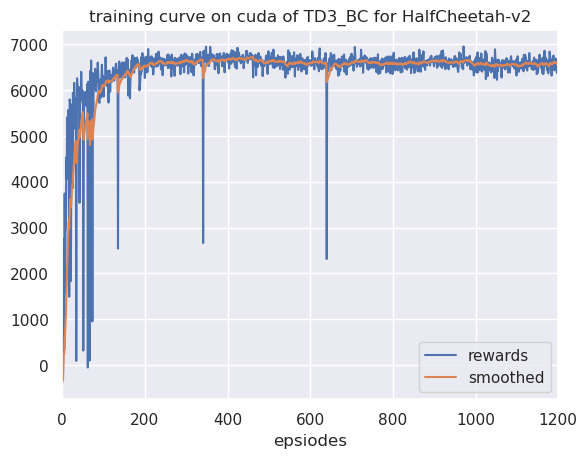

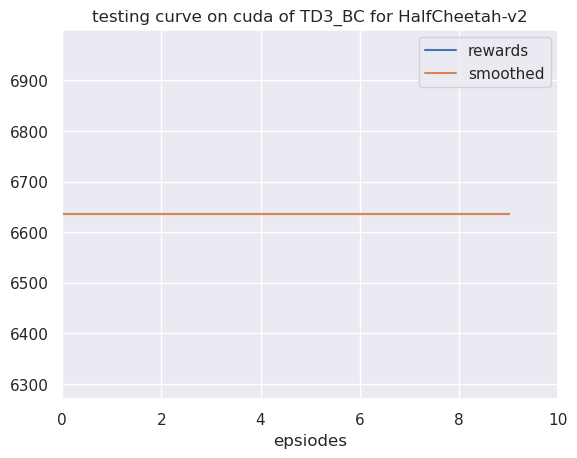

In [17]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)

plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic, agent = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果

In [19]:
agent.save_model('./HalfCheetah-v2_TD3_BC_model')